# Pipeline Bits

We demonstrate some elememts of the analysis pipleline, in particular:
* Init of all gravsphere densities
* Computation of all potentials
* Round trip sanity check, i.e. M(r) -> V(r) -> rho(r) equal to rho(r) from gravsphere?
* Single draw computation of the eigenstate library
* Optimsation of wave function coefficients for a single eigenstate library

What we don't demonstrate here is:
* Mechanism to compute *all* eigenstate libraries concurrently (currently not pmappable)
* Mechanism to find coeffcients for *all* eigenstate libraries concurrently (trivial-ish)
* Histogramming the distance measure (trivial)

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys

In [2]:
%load_ext autoreload
%autoreload 2
import jaxsp as jsp

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
plt.style.use("./mnras.mplstyle")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

data_dir = "../data/"
cache_dir = "../data/cache"
dsph = "LeoII"
load_if_available=True
save=True

m22 = 10
u = jsp.set_schroedinger_units(m22)

/tmp/ipykernel_12026/2735305173.py:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [16]:
init_core_NFW_tides_params_from_chain = jax.vmap(jsp.init_core_NFW_tides_params_from_sample)
init_potentials_params = jax.vmap(jsp.init_potential_params, in_axes=(0,0,0,None))
enclosing_radius = jax.vmap(jsp.enclosing_radius, in_axes=(None,0))


rho = jax.vmap(jax.vmap(jsp.rho, in_axes=(0,None)), in_axes=(None,0))
enclosed_mass = jax.vmap(jax.vmap(jsp.enclosed_mass, in_axes=(0,None)), in_axes=(None,0))
total_mass = jax.vmap(jsp.total_mass)
potentials = jax.vmap(jax.vmap(jsp.potential, in_axes=(0,None)), in_axes=(None,0))
eigenstates = jax.vmap(jax.vmap(jsp.eval_eigenstate, in_axes=(0,None)), in_axes=(None,0))
rho_psi = jax.vmap(jsp.rho_psi, in_axes=(0,None))

### GravSphere Data

In [5]:
N_samples = 1024
chain_data_raw = np.loadtxt(f"{data_dir}/coreNFWtides_parameters/output_M200c200_chain_{dsph}.txt")
chain_data = np.copy(chain_data_raw[:N_samples, :])
chain_data[:,0] *= u.from_Msun
chain_data[:,3] *= u.from_Kpc
chain_data[:,4] *= u.from_Kpc

In [6]:
densities_params = jsp.load_or_compute_model(
    load_if_available,
    cache_dir,
    jsp.core_NFW_tides_params.compute_name(chain_data),
    init_core_NFW_tides_params_from_chain,
    chain_data
)
if save:
    jsp.save_model(cache_dir, 
                   densities_params.compute_name(chain_data), 
                   densities_params
    )

INFO:jaxsp.io_utils:Model already computed. Load 1215330689...
INFO:jaxsp.io_utils:Save 1215330689...


In [7]:
r95 = enclosing_radius(0.95, densities_params)
r99 = enclosing_radius(0.99, densities_params)
r999 = enclosing_radius(0.9999, densities_params)
k = 42 #jnp.argmin(jnp.abs(r99 - jnp.median(r99)))
r99max = jnp.max(r99)

rr = jnp.logspace(-3,jnp.log10(r99max * u.to_Kpc), 1000) * u.from_Kpc
M_samples = enclosed_mass(rr, densities_params)
rho_samples = rho(rr, densities_params)

density_params = jsp.init_core_NFW_tides_params_from_sample(chain_data[k])

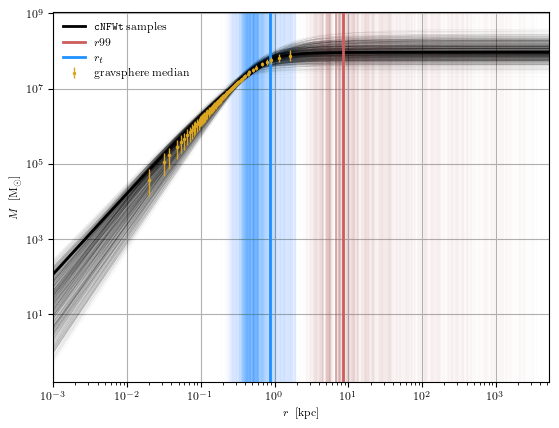

In [8]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

for i in range(N_samples):
    ax.plot(rr * u.to_Kpc, M_samples[i,:]* u.to_Msun, c="k", alpha=0.1,lw=0.15)
    ax.axvline(x=r99[i] * u.to_Kpc, c="indianred", lw=0.15, alpha=0.1)
    ax.axvline(x=densities_params.rt[i] * u.to_Kpc, c="dodgerblue", lw=0.15, alpha=0.1)

ax.plot(rr * u.to_Kpc, M_samples[k,:]* u.to_Msun, c="k",
        label=r"$\texttt{cNFWt}\mathrm{\;samples}$")
ax.axvline(x=r99[k] * u.to_Kpc, c="indianred", label=r"$r99$")
ax.axvline(x=density_params.rt * u.to_Kpc, c="dodgerblue", label=r"$r_t$")

r, M_r, m_sigma_M, p_sigma_M = np.loadtxt(f"{data_dir}/Mass_profiles/coreNFW_masses/output_M_{dsph}.txt", 
                                          usecols=(0,1,2,3), unpack=True)
asymmetric_error = [M_r - m_sigma_M, p_sigma_M - M_r]

ax.errorbar(r, M_r, yerr=asymmetric_error, 
            fmt='.', lw=1, c="goldenrod",markersize=3, 
            label=r"$\mathrm{gravsphere\;median}$")

ax.set_xlabel(r"$r\;\;\mathrm{[kpc]}$")
ax.set_ylabel(r"$M\;\;\mathrm{[M_\odot]}$")
ax.legend(*ax.get_legend_handles_labels())
plt.show()

### Potentials

In [9]:
def init_potential_sample(k, potentials_params):
    return jsp.init_1d_interpolation_params(a=potentials_params.a[k], 
                                            dx=potentials_params.dx[k],
                                            f=potentials_params.f[k]) 
    
rmin = jnp.array([1e-3 * u.from_Kpc] * N_samples)
N = 256
potentials_params = jsp.load_or_compute_model(load_if_available, 
                                              cache_dir, 
                                              jsp.potential_params.compute_name(densities_params, rmin,r999,N), 
                                              init_potentials_params,
                                              densities_params,
                                              rmin, r999, N)
if save:
    jsp.save_model(cache_dir, 
                   potentials_params.compute_name(densities_params, rmin, r999, N),
                   potentials_params
                  )

potential_params = jsp.potential_params(
    name=potentials_params.name[k],
    interpolation_params=jsp.interpolation_params(
        a=potentials_params.interpolation_params.a[k],
        dx=potentials_params.interpolation_params.dx[k],
        f=potentials_params.interpolation_params.f[k],
        lb=potentials_params.interpolation_params.lb[k],
        ub=potentials_params.interpolation_params.ub[k],
    )
)

INFO:jaxsp.io_utils:Model already computed. Load 1262135273...
INFO:jaxsp.io_utils:Save 1262135273...


In [10]:
V_r = potentials(rr, potentials_params)

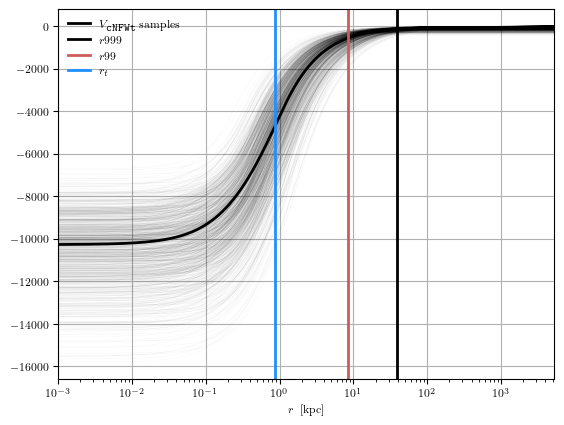

In [11]:
fig, ax = plt.subplots()
ax.set_xscale("log")

for i in range(N_samples):
    ax.semilogx(rr * u.to_Kpc, V_r[i,:], c="k", alpha=0.08, lw=0.15)
ax.semilogx(rr * u.to_Kpc, V_r[k,:], c="k", label=r"$V_\texttt{cNFWt}\mathrm{\;samples}$")
ax.axvline(x=r999[k] * u.to_Kpc, c="black", label=r"$r999$")
ax.axvline(x=r99[k] * u.to_Kpc, c="indianred", label=r"$r99$")
ax.axvline(x=density_params.rt * u.to_Kpc, c="dodgerblue", label=r"$r_t$")
plt.xlabel(r"$r\;\;\mathrm{[kpc]}$")
ax.legend(*ax.get_legend_handles_labels())
plt.show()

### Sanity Check

In [12]:
from functools import partial 

@partial(jax.vmap, in_axes=(0,None))
def M_from_V(r, potential_params):
    dV = jax.grad(lambda r: jsp.potential(r, potential_params))
    return 4*jnp.pi * r**2 * dV(r)

@partial(jax.vmap, in_axes=(0,None))
def rho_from_V(r, potential_params):
    dV = jax.grad(lambda r: jsp.potential(r, potential_params))
    d2V = jax.grad(dV)
    return d2V(r) + 2.0/r * dV(r)

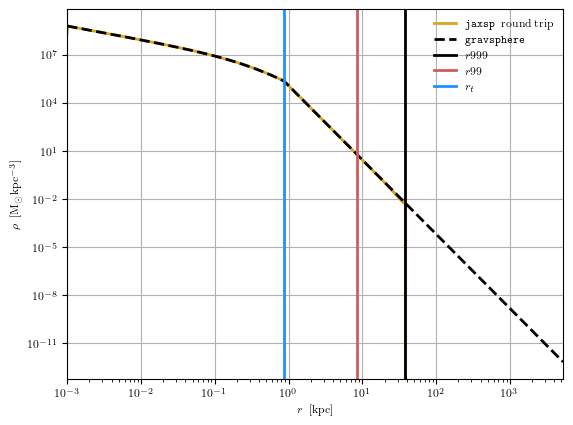

In [13]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(rr * u.to_Kpc, rho_from_V(rr, potential_params), c="goldenrod",
        label=r"$\texttt{jaxsp}\mathrm{\;\;round\;trip}$")
ax.plot(rr * u.to_Kpc, rho_samples[k,:], c="k", ls="dashed", 
        label=r"$\texttt{gravsphere}$")
ax.axvline(x=r999[k] * u.to_Kpc, c="black", label=r"$r999$")
ax.axvline(x=r99[k] * u.to_Kpc, c="indianred", label=r"$r99$")
ax.axvline(x=density_params.rt * u.to_Kpc, c="dodgerblue", label=r"$r_t$")

ax.legend(*ax.get_legend_handles_labels())
plt.xlabel(r"$r\;\;\mathrm{[kpc]}$")
plt.ylabel(r"$\rho\;\;\mathrm{[M_\odot kpc^{-3}]}$")

plt.show()

### Eigenstate Library

In [14]:
N = 4096
lib = jsp.load_or_compute_model(
    load_if_available,
    cache_dir,
    jsp.eigenstate_library.compute_name(potential_params, r99[k], N),
    jsp.init_eigenstate_library,
    potential_params, r99[k], N
)
if save:
    jsp.save_model(cache_dir, 
                   lib.compute_name(potential_params, r99[k], N),
                   lib
    )
print(lib)

INFO:jaxsp.io_utils:Model already computed. Load 615083249...
INFO:jaxsp.io_utils:Save 615083249...
wavefunction_params:
	name=615083249,
	J=195,
	lmax=20.0,
	nmax=16,
	Emin=-7445.581618756344,
	Emax=-572.4827668173245,


In [18]:
R_j_r = eigenstates(rr, lib.R_j_params)

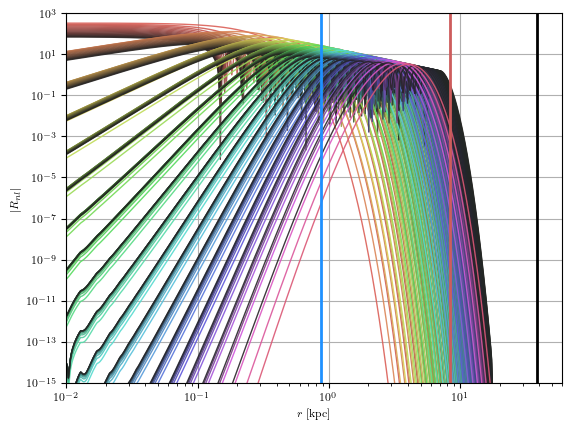

In [22]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

base_color = sns.color_palette("hls", int(max(lib.l_of_j))+1)
colors = [sns.dark_palette(base, nc, reverse=True) 
          for base, nc in zip(base_color, np.r_[np.diff(np.where(lib.n_of_j == 0)[0]),1])]

ax.set_ylabel(r"$|R_{nl}|$")
for j in range(lib.J):
    l = int(lib.l_of_j[j])
    n = int(lib.n_of_j[j])

    ax.plot(rr * u.to_Kpc, np.abs(R_j_r[j,:]), color=colors[l][n], lw=1, alpha=0.9)
    #ax.plot(lib.R_j_params.x_j[j] * u.to_Kpc, jnp.abs(lib.R_j_params.f_j[j]), 
    #        color=colors[l][n], lw=1, alpha=0.9)
ax.axvline(x=r999[k] * u.to_Kpc, c="black", label=r"$r999$")
ax.axvline(x=r99[k] * u.to_Kpc, c="indianred", label=r"$r99$")
ax.axvline(x=density_params.rt * u.to_Kpc, c="dodgerblue", label=r"$r_t$")    
ax.set_xlabel(r"$r\; \mathrm{[kpc]}$")
ax.set_ylim([1e-15, 1e3])
ax.set_xlim([1e-2, 6e1])
plt.show()

In [27]:
wavefunction_params = jsp.load_or_compute_model(
    load_if_available,
    cache_dir,
    jsp.wavefunction_params.compute_name(lib, densities_params, r99[k]),
    jsp.init_wavefunction_params_least_square,
    lib, 
    density_params,  
    r99[k]
)
if save:
    jsp.save_model(cache_dir, 
                   wavefunction_params.compute_name(lib, densities_params, r99[k]),
                   wavefunction_params
    )
print(wavefunction_params)

INFO:jaxsp.io_utils:Model already computed. Load 562134806...
INFO:jaxsp.io_utils:Save 562134806...
wavefunction_params:
	name=1253597714,
	eigenstate_library=615083249,
	aj_2=[Array(4.75884587e-11, dtype=float64), Array(0.14905968, dtype=float64)],
	total_mass=9044.338136170656,
	distance=1.0480103792891846,


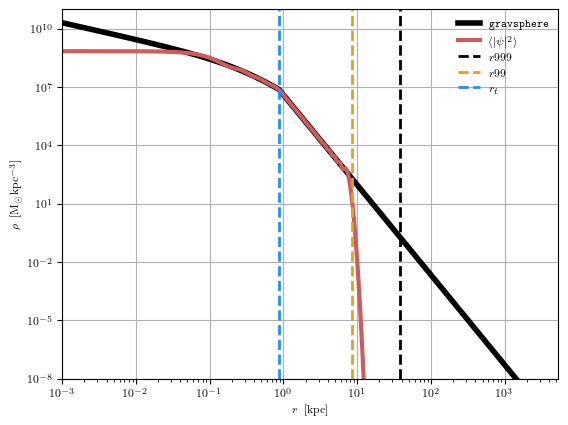

In [29]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(rr * u.to_Kpc, rho_samples[k,:] * u.to_Msun/u.to_Kpc**3, c="k", lw=4,
        label=r"$\texttt{gravsphere}$")
ax.plot(rr * u.to_Kpc, rho_psi(rr, wavefunction_params) * u.to_Msun/u.to_Kpc**3, 
        c="indianred", label=r"$\langle |\psi|^2 \rangle$", lw=3)
ax.axvline(x=r999[k] * u.to_Kpc, c="black", label=r"$r999$",ls="dashed")
ax.axvline(x=r99[k] * u.to_Kpc, c="goldenrod", label=r"$r99$",ls="dashed")
ax.axvline(x=density_params.rt * u.to_Kpc, c="dodgerblue", label=r"$r_t$",ls="dashed")

ax.legend(*ax.get_legend_handles_labels())
plt.xlabel(r"$r\;\;\mathrm{[kpc]}$")
plt.ylabel(r"$\rho\;\;\mathrm{[M_\odot kpc^{-3}]}$")
ax.set_ylim([1e-8, 1e11])
plt.show()